In [7]:
import pandas as pd
from bs4 import BeautifulSoup
import requests
import json
from pandas.io.json import json_normalize
from selenium import webdriver
import time
import re
import matplotlib.pyplot as plt
import numpy as np

<h1>데이터 가져오기

크롤링 후 전처리한 데이터 가져오기

In [3]:
file_path = 'C:/Users/elris/Python/기업텍스트.xlsx'

data = pd.read_excel(file_path, sheet_name='Sheet1')

In [14]:
from ekonlpy.tag import Mecab
mecab = Mecab()
for num, i in enumerate(data['내용']) : 
    token_list = ''
    token = mecab.pos(i)
    for k in token :
        token_list += k[0]
        token_list += ' '
    data['내용'][num] = token_list

C:\Users\elris\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [12]:
data.head()

,Unnamed: 0,연도,회사명,종목코드,업종,보고서,발행일,내용
0,0,2009,CS홀딩스,590,기타 금융업,사업보고서 (2009.12),20100331,이사 의 경영진단 및 분석 의견 1 . 개요 지난 한 해 를 돌이켜 볼 때 우리 는...
1,1,2009,주연테크,44380,컴퓨터 및 주변장치 제조업,사업보고서 (2009.12),20100331,이사 의 경영진단 및 분석 의견 1 . 예측 정보 에 대한 주 의 사항 당사 가 동...
2,2,2009,국도화학,7690,기초 화학물질 제조업,사업보고서 (2009.12),20100330,이사 의 경영진단 및 분석 의견 1 . 예측 정보 에 대한 주 의 사항 당사 가 동...
3,3,2009,광주신세계,37710,종합 소매업,사업보고서 (2009.12),20100331,이사 의 경영진단 및 분석 의견 1 . 예측 정보 에 대한 주 의 사항 당사 가 동...
4,4,2009,세방전지,4490,일차전지 및 축전지 제조업,사업보고서 (2009.12),20100331,이사 의 경영진단 및 분석 의견 1 . 예측 정보 에 대한 주 의 사항 당사 가 동...


In [8]:
def length_adjust(str_) : 
    return (2-len(str_)) * '0' + str_

def date_convertor(date) : 
    year = length_adjust(str(date.year))
    month = length_adjust(str(date.month))
    day = length_adjust(str(date.day))
    yyyymmdd = int(year+month+day)
    return yyyymmdd

In [9]:
lv2_index = pd.date_range(start='20100101', end='20191231')
lv2_index = list(map(date_convertor,lv2_index))
lv2_columns = data['회사명'].unique()

lv2_df = \
pd.DataFrame(np.full(shape=(len(lv2_index),len(lv2_columns)),fill_value=np.nan),index=lv2_index,columns=lv2_columns)

<h1>자카드 유사도

자카드 지수(Jaccard index)는 두 집합 사이의 유사도를 측정하는 방법 중 하나이다.  <br>자카드 지수는 0과 1 사이의 값을 가지며, 두 집합이 동일하면 1의 값을 가지고, 공통의 원소가 하나도 없으면 0의 값을 가진다. 자카드 지수는 아래의 식으로 정의된다.

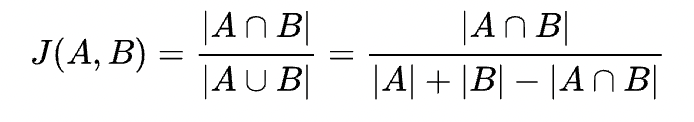

In [10]:
%%time
company_list = data['회사명'].unique()
for process,corp_name in enumerate(company_list) : 
    print("Process : {} | Total : {}".format(process+1,len(company_list)),end='\r')
    # slicing the dataset by corp_name
    tmp_df = data[data['회사명'] == corp_name]
    
    # set-up the time range 
    min_yr = tmp_df['연도'].min()
    max_yr = tmp_df['연도'].max()
    
    # container for saving the value 
    # those lists should be refreshed every loop.
    sim_ls = []; year_ls = []
    
    for yr in range(min_yr,max_yr) : 
        pre_df = tmp_df[tmp_df['연도'] == yr]
        next_df = tmp_df[tmp_df['연도'] == yr+1]
        publish_date = tmp_df[tmp_df['연도'] == yr+1]['발행일']
        if len(pre_df) == 0 or len(next_df) == 0:
            continue
            # we don't have data
            # for example, we have 2014 but don't 2015.
            # therfore we can't measure similarity between 2014,2015.
            # so the value in lv2 at 2015 should be nan
            
        else : 
            pre_token = pre_df['내용'].map(lambda x : x.split(" ")).values
            next_token = next_df['내용'].map(lambda x : x.split(" ")).values   
            if type(pre_token[0]) == list and type(next_token[0]) == list :
                sim = len(set(next_token[0])&set(pre_token[0]))/len(set(next_token[0]))
            else : 
                 sim = len(set(next_token)&set(pre_token))/len(set(next_token))
        year_ls.append(publish_date.values[0])
        sim_ls.append(sim)
        
    assert len(year_ls) == len(sim_ls)
    lv2_df.loc[year_ls,corp_name] = sim_ls    

Wall time: 28.8 sotal : 781


In [11]:
lv2_df.mean()

CS홀딩스        0.772146
주연테크         0.719782
국도화학         0.750801
광주신세계        0.819690
세방전지         0.867543
S&TC         0.898368
제주은행         0.798649
한익스프레스       0.806586
태원물산         0.784049
무림P&P        0.709589
LG전자         0.646246
한성기업         0.801206
한국화장품제조      0.769476
한전KPS        0.732746
조광피혁         0.732616
텔코웨어         0.814024
일성신약         0.761710
대웅제약         0.838582
SPC삼립        0.796290
동성화학         0.684452
한농화성         0.793406
한화투자증권       0.631658
삼영무역         0.770433
한국금융지주       0.678619
한양증권         0.765427
유안타증권        0.832912
S-Oil        0.772415
제일파마홀딩스      0.853680
하이스틸         0.737263
신세계푸드        0.787443
               ...   
제일약품         0.684783
오리온          0.914062
넷마블          0.608475
테이팩스         0.739414
경동도시가스       0.819444
미원에스씨        0.951299
롯데제과         0.938776
신한알파리츠       0.956522
쿠쿠홈시스        0.825221
애경산업         0.914062
이리츠코크렙       0.958115
대우조선해양       0.641026
코스모화학             NaN
코스모신소재            NaN
드림텍       